# Position and rotation estimation with pooling layers and RGB images

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import random
import math

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU

# Preparing data

In [43]:
DATADIR = "dataset_generator/images/pos_and_rot_3/"
JSON_file_name = "data.txt"
IMAGES = 2_000
OG_IMG_SIZE = 800
IMG_SIZE = 150

In [44]:
data_json = []
for line in open(DATADIR + JSON_file_name, 'r'):
    data_json.append(json.loads(line))
    
dataset = [] # [x, y]

for img in os.listdir(DATADIR):
    if(img.endswith(".jpg")):
        img_array = cv2.imread(os.path.join(DATADIR, img))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        img_index = int(img.strip(".jpg"))
        for label in data_json:
            if(label['index'] == img_index):
                choosen_label = {'bx': label['bx'], 
                                 'by': label['by'], 
                                 'bw': label['bw'], 
                                 'bh': label['bh'], 
                                 'posX': label['posX'], 
                                 'posY': label['posY'], 
                                 'posZ': label['posZ'],
                                 'rotX': label['rotX'],
                                 'rotY': label['rotY']}
                
                xy = [img_array, choosen_label]
                dataset.append(xy)
                
        if(len(dataset)%500 ==0):
            print(f"{len(dataset)} images loaded")
        
        if(len(dataset) >= IMAGES):
            print("All images loaded")
            break
            
IMAGES = len(dataset)
print(f"{IMAGES} in total")

500 images loaded
1000 images loaded
1500 images loaded
2000 images loaded
All images loaded
2000 in total


# Creating training dataset

In [45]:
X = []
y = []

shuffled_indices = random.sample(range(0, IMAGES), IMAGES)

for i in shuffled_indices:
    
    pixels = dataset[i][0]
    pixels = pixels.astype('uint8')
    X.append(pixels)
    
    y_labels = [dataset[i][1]['bx'], 
                dataset[i][1]['by'], 
                dataset[i][1]['bw'], 
                dataset[i][1]['bh'], 
                dataset[i][1]['posX'], 
                dataset[i][1]['posY'], 
                dataset[i][1]['posZ'],
                dataset[i][1]['rotX'],
                dataset[i][1]['rotY']]
    
    y.append(y_labels)

# Global Standardization
X = (np.array(X).reshape(IMAGES, IMG_SIZE, IMG_SIZE, 3) - np.mean(X)) / np.std(X)
    
for index, ya in enumerate(y):
    y[index] = np.array([ya[0]/100, ya[1]/100, ya[2]/100, ya[3]/100, ya[4]/10, ya[5]/10, ya[6]/10, ya[7]/360, ya[8]/360])
    
y = np.array(y)

print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (2000, 150, 150, 3)
y shape: (2000, 9)


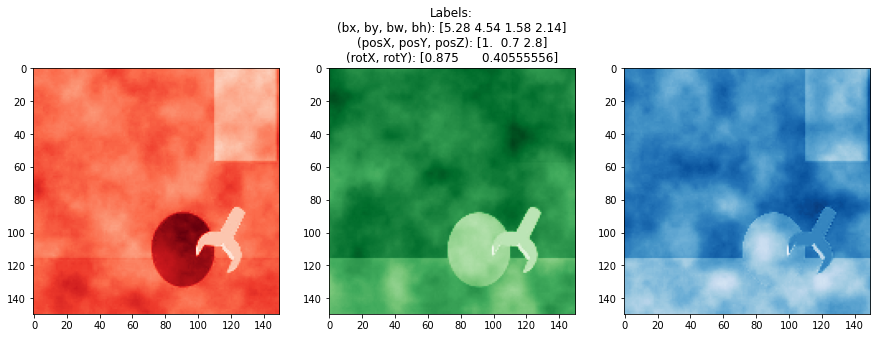

In [46]:
random_index = random.randrange(IMAGES)
fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

axs[1].set_title(f"Labels:\n(bx, by, bw, bh): {y[random_index][:4]}\
\n(posX, posY, posZ): {y[random_index][4:7]}\
\n(rotX, rotY): {y[random_index][7:9]}")

plt.show()

# Model

### Custom accuracy metric

In [47]:
def acc15(y_true, y_pred):
    threshold = 15
    count = tf.reduce_sum(tf.cast(K.less(K.abs(y_true-y_pred), threshold), tf.float32))

    return count

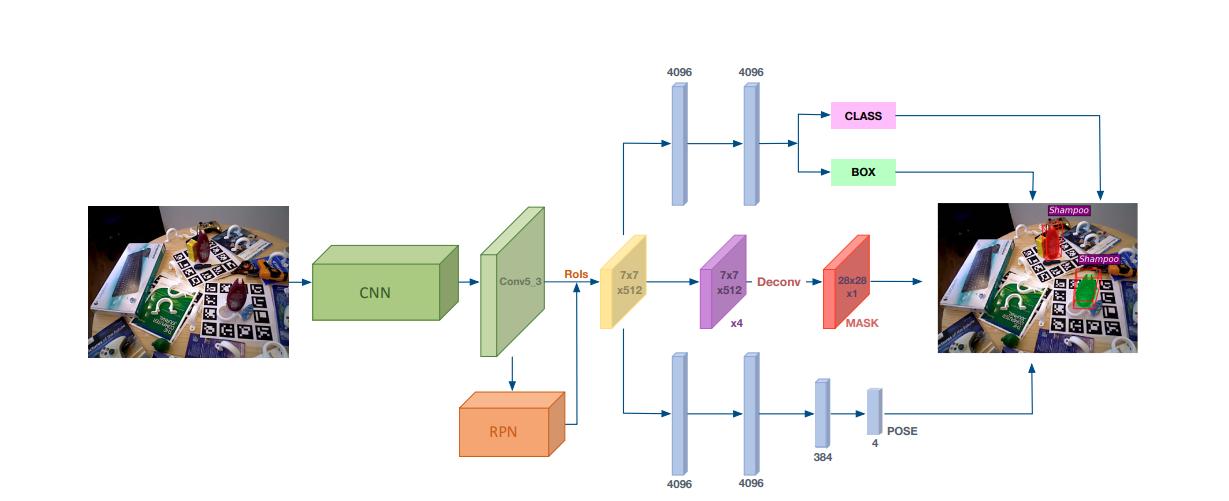

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
ms_conv_1 (Conv2D)              (None, 148, 148, 16) 448         Inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_35 (LeakyReLU)      (None, 148, 148, 16) 0           ms_conv_1[0][0]                  
__________________________________________________________________________________________________
ms_maxpooling_1 (MaxPooling2D)  (None, 74, 74, 16)   0           leaky_re_lu_35[0][0]             
______________________________________________________________________________________________

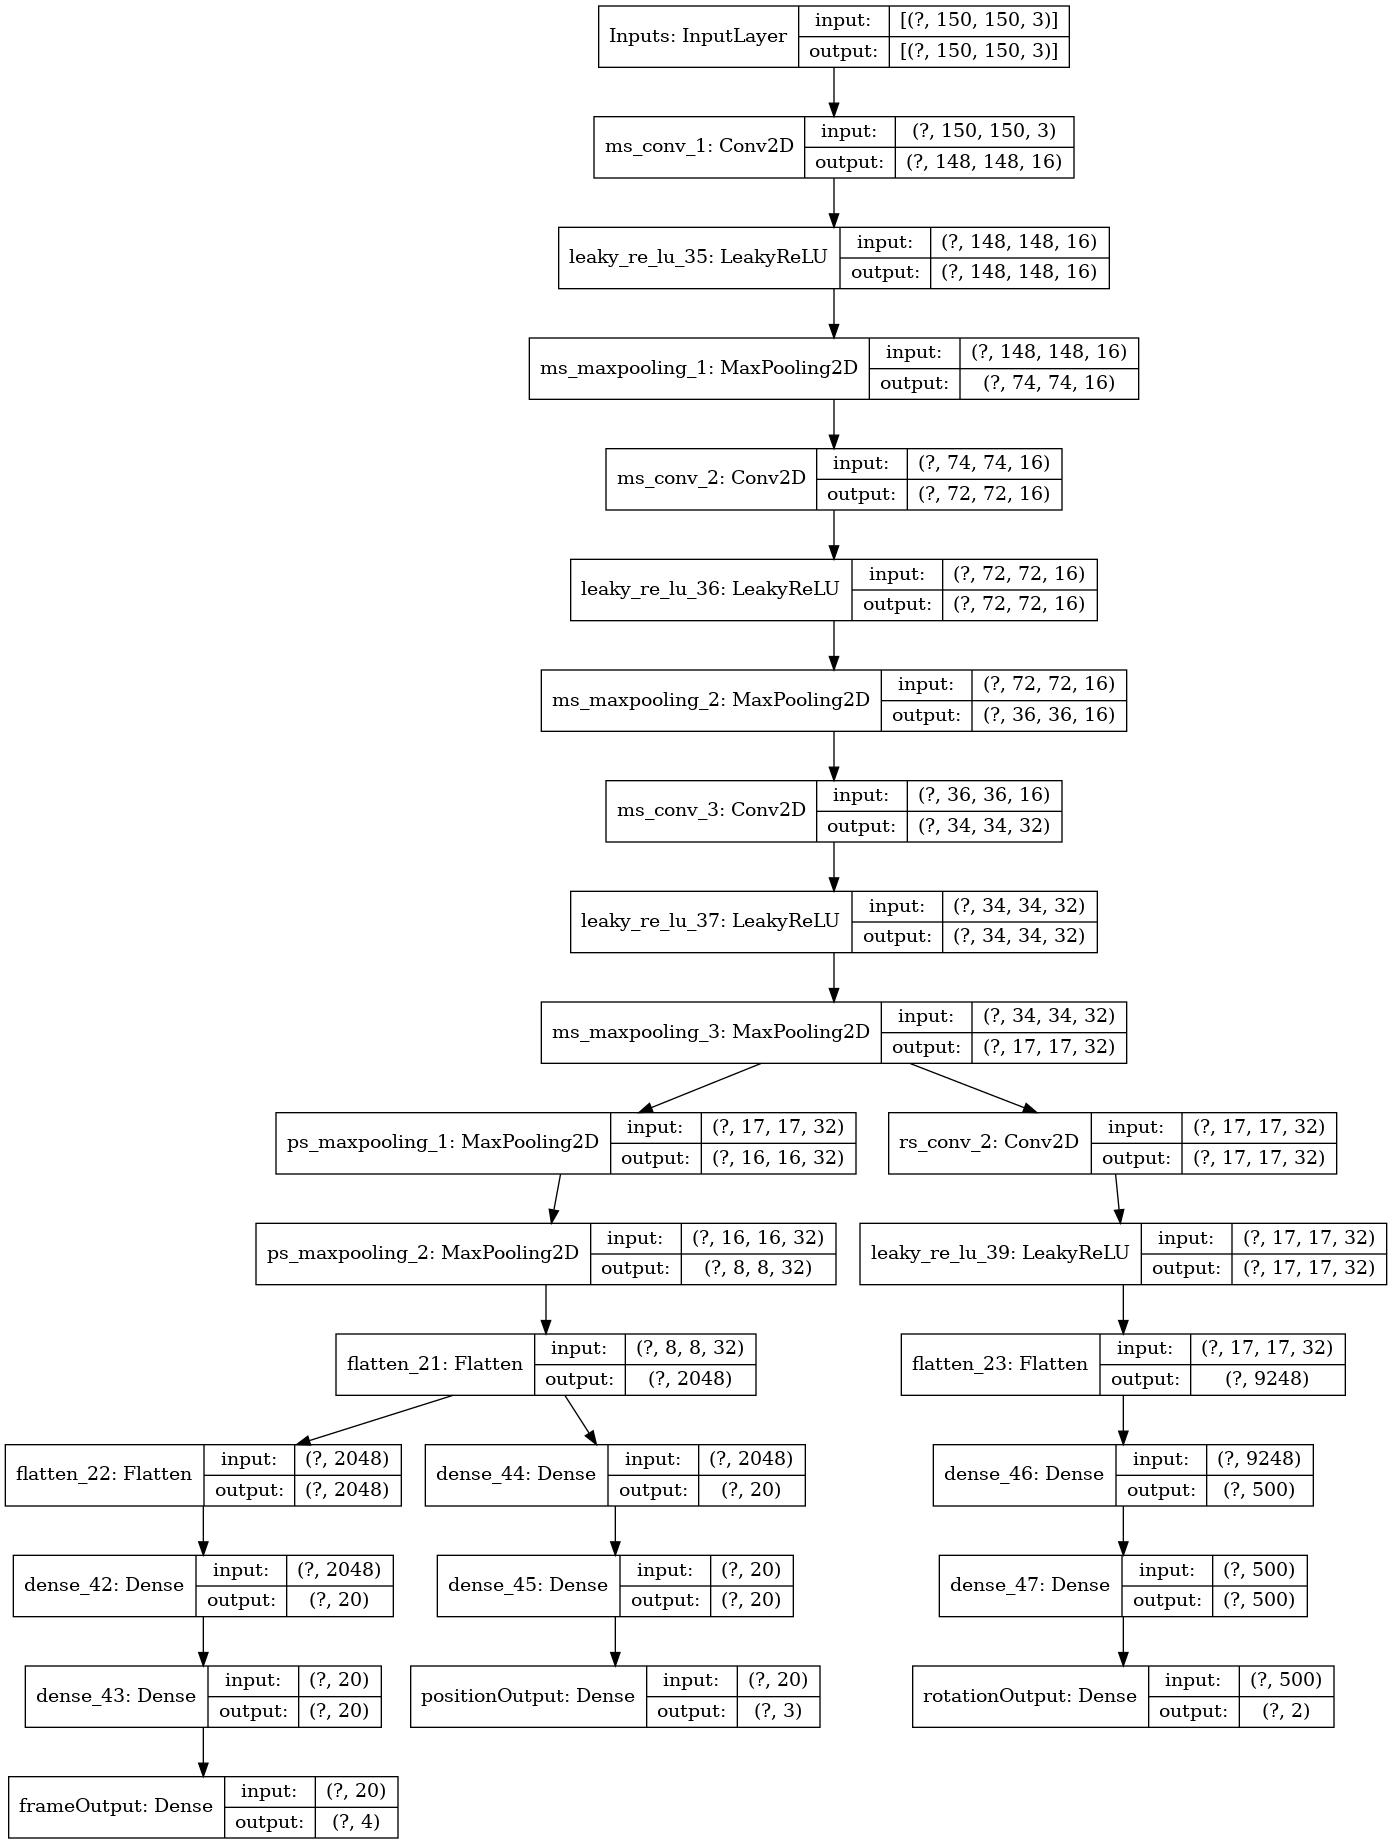

In [65]:
inputs = Input(name = "Inputs",
              shape = (IMG_SIZE, IMG_SIZE, 3))

# Main Stream
mainStream = Conv2D(name = "ms_conv_1",
                   filters = 16,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer='he_uniform')(inputs)

mainStream = LeakyReLU()(mainStream)

mainStream = MaxPooling2D(name="ms_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 2)(mainStream)

mainStream = Conv2D(name = "ms_conv_2",
                   filters = 16,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
#                    kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)
                    kernel_initializer='he_uniform')(mainStream)


mainStream = LeakyReLU()(mainStream)

mainStream = MaxPooling2D(name="ms_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(mainStream)

mainStream = Conv2D(name = "ms_conv_3",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer='he_uniform')(mainStream)

mainStream = LeakyReLU()(mainStream)

mainStream = MaxPooling2D(name="ms_maxpooling_3", 
                          pool_size = (2, 2), 
                          strides = 2)(mainStream)


# Position Stream
positionStream = MaxPooling2D(name="ps_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 1)(mainStream)

positionStream = MaxPooling2D(name="ps_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

positionStream = Flatten()(positionStream)

# Frame Stream
frameStream = Flatten()(positionStream)
frameStream = Dense(20, activation = "relu")(frameStream)
frameStream = Dense(20, activation = "relu")(frameStream)
frameStream = Dense(4, name = "frameOutput")(frameStream)

positionStream = Dense(20, activation = "relu")(positionStream)
positionStream = Dense(20, activation = "relu")(positionStream)
positionStream = Dense(3, name = "positionOutput")(positionStream)

# Rotation Stream
roationStream = Conv2D(name = "rs_conv_1",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer='he_uniform')(mainStream)

roationStream = LeakyReLU()(roationStream)

roationStream = Conv2D(name = "rs_conv_2",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer='he_uniform')(mainStream)

roationStream = LeakyReLU()(roationStream)

roationStream = Flatten()(roationStream)
roationStream = Dense(500, activation = "relu")(roationStream)
roationStream = Dense(500, activation = "relu")(roationStream)
roationStream = Dense(2, name = "rotationOutput")(roationStream)


model = keras.Model(inputs, [positionStream, roationStream, frameStream], name = "Model")

model_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    amsgrad=False)

model_loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer = model_optimizer,
             loss = [model_loss, model_loss, model_loss])

model.summary()
keras.utils.plot_model(model, "model.png", show_shapes=True)

# Training

In [66]:
history = model.fit(x = X,
                   y = {"frameOutput": y[:, 0:4], "positionOutput": y[:, 4:7], "rotationOutput": y[:, 7:9]},
                   batch_size = 32,
                   epochs = 15,
                   validation_split = 0.2)

Epoch 1/15
50/50 [==============================] - 9s 181ms/step - loss: 15.9478 - positionOutput_loss: 0.9439 - rotationOutput_loss: 13.0569 - frameOutput_loss: 1.9470 - val_loss: 1.3649 - val_positionOutput_loss: 0.3559 - val_rotationOutput_loss: 0.0567 - val_frameOutput_loss: 0.9523
Epoch 2/15
50/50 [==============================] - 9s 172ms/step - loss: 1.1717 - positionOutput_loss: 0.3123 - rotationOutput_loss: 0.0541 - frameOutput_loss: 0.8053 - val_loss: 1.0170 - val_positionOutput_loss: 0.2861 - val_rotationOutput_loss: 0.0598 - val_frameOutput_loss: 0.6710
Epoch 3/15
50/50 [==============================] - 9s 175ms/step - loss: 0.8741 - positionOutput_loss: 0.2425 - rotationOutput_loss: 0.0451 - frameOutput_loss: 0.5865 - val_loss: 0.8577 - val_positionOutput_loss: 0.2235 - val_rotationOutput_loss: 0.0640 - val_frameOutput_loss: 0.5703
Epoch 4/15
50/50 [==============================] - 9s 174ms/step - loss: 0.7351 - positionOutput_loss: 0.1886 - rotationOutput_loss: 0.0417

loss
positionOutput_loss
rotationOutput_loss
frameOutput_loss
val_loss
val_positionOutput_loss
val_rotationOutput_loss
val_frameOutput_loss


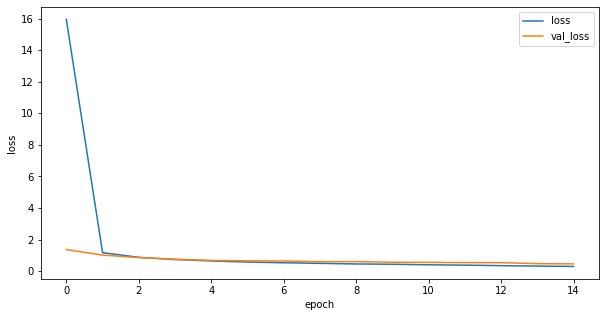

In [68]:
for k in history.history.keys():
    print(k)

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10,5))

axs.plot(history.history['loss'], label = "loss")
axs.plot(history.history['val_loss'], label = "val_loss")
axs.set_ylabel('loss')
axs.set_xlabel('epoch')
axs.legend(loc='upper right')

plt.show()

# Results

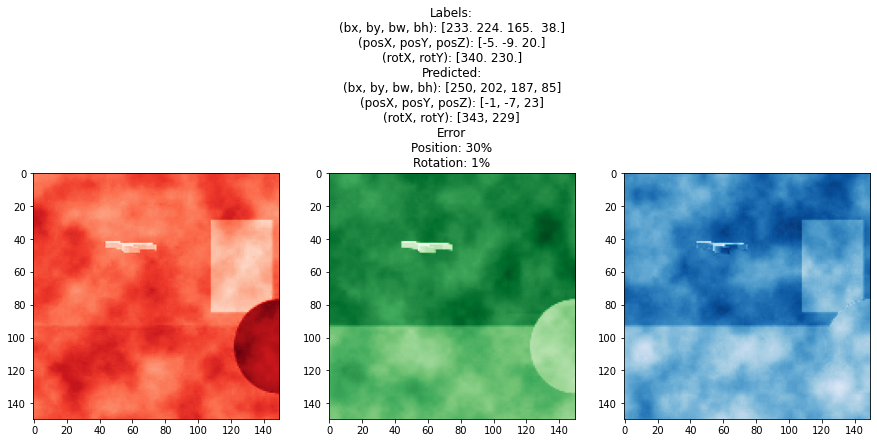

In [87]:
random_index = random.randrange(IMAGES)

prediction = model.predict(X[random_index].reshape(1, IMG_SIZE, IMG_SIZE, 3))

fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

frame_og = y[random_index][:4]*100
pos_og = y[random_index][4:7]*10
rot_og = y[random_index][7:9]*360

frame_pred = [int(p*100) for p in prediction[2][0]]
pos_pred = [int(p*10) for p in prediction[0][0]]
rot_pred = [int(p*360) for p in prediction[1][0]]

pos_error = int(sum((abs(pos_pred-pos_og)/30)*100))
rot_error = int(sum(abs((rot_pred-rot_og)/360)*100))

axs[1].set_title(f"Labels:\
\n(bx, by, bw, bh): {frame_og}\
\n(posX, posY, posZ): {pos_og}\
\n(rotX, rotY): {rot_og}\n\
Predicted:\
\n(bx, by, bw, bh): {frame_pred}\
\n(posX, posY, posZ): {pos_pred}\
\n(rotX, rotY): {rot_pred}\
\nError\
\nPosition: {pos_error}%\
\nRotation: {rot_error}%")

plt.show()

# Layer output extraction

In [70]:
def extract_layer_data(layer):
    submodel = keras.Model(inputs = model.input, outputs = layer.output)
    submodel_output = submodel.predict(np.array(X[random_index]).reshape(1, IMG_SIZE, IMG_SIZE, 3))
    output_shape = submodel_output.shape
    
    graph_size = 10
    
    index = 0
    if (len(output_shape) != 2):
        if(output_shape[-1]>=4):
            fig, axs = plt.subplots(4, int(output_shape[-1]/4), figsize=(graph_size, graph_size))
            fig.suptitle(f"{layer.name}, [{output_shape}]")
            for col in range(0, 4):
                for row in range(0, int(output_shape[-1]/4)):
                    axs[col, row].imshow(submodel_output[0, :, :, index], cmap="Greys")
                    index += 1
                    axs[col, row].axis('off')
            
        else:
            fig, axs = plt.subplots(ncols = output_shape[-1], figsize=(graph_size, graph_size))
            for col in range(0, output_shape[-1]):
                axs[col].imshow(submodel_output[0, :, :, index], cmap="Greys")
                if(int(output_shape[-1]/2) == col):
                    axs[col].set_title(f"{layer.name}, [{output_shape}]")
                index += 1
                axs[col].axis('off')
    plt.tight_layout()

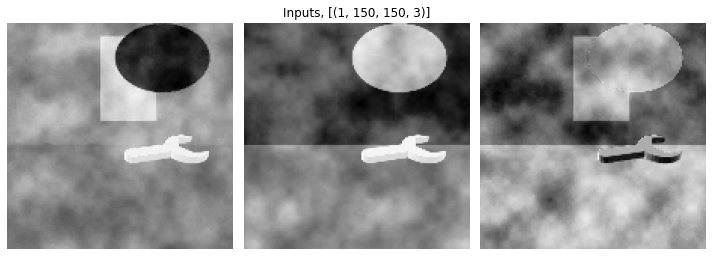

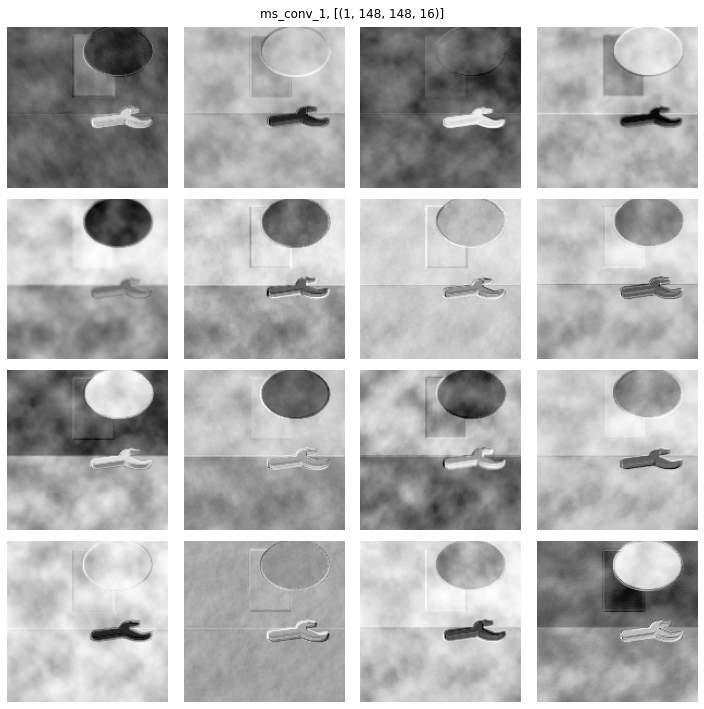

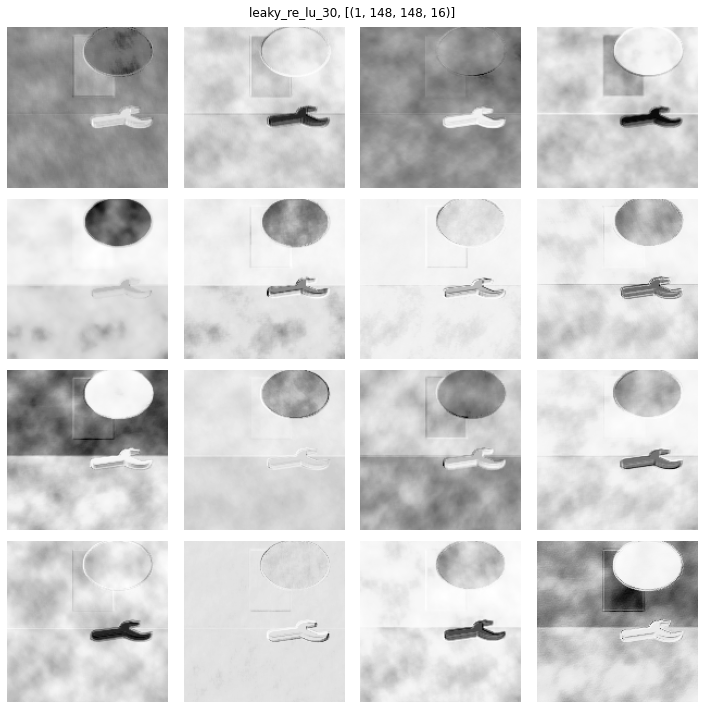

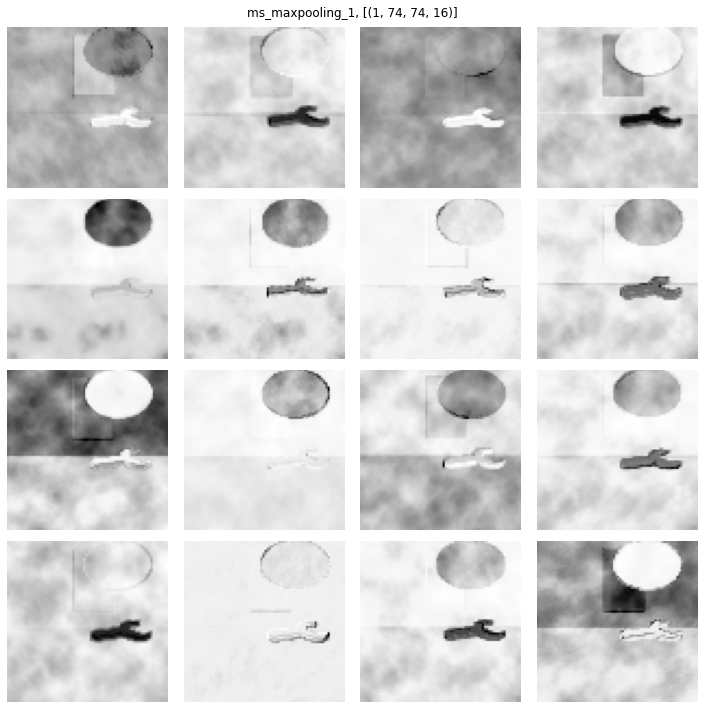

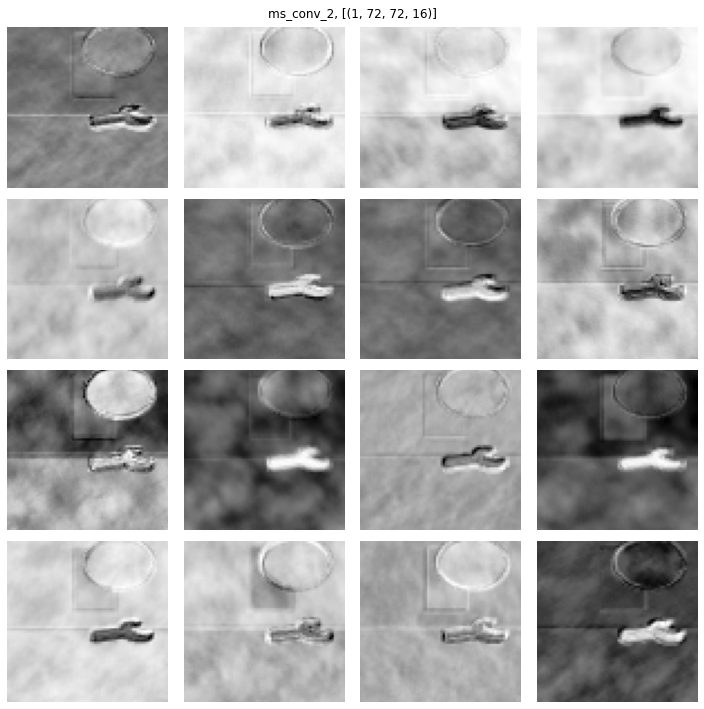

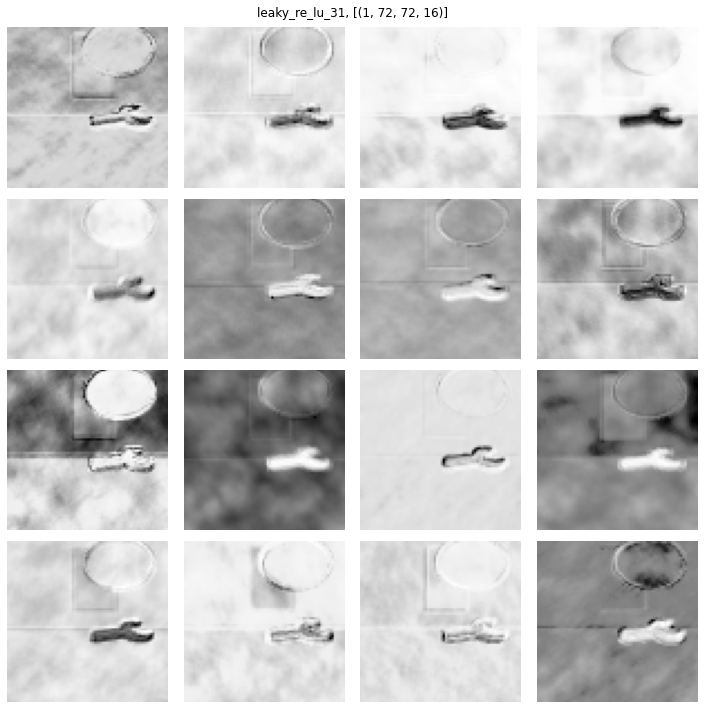

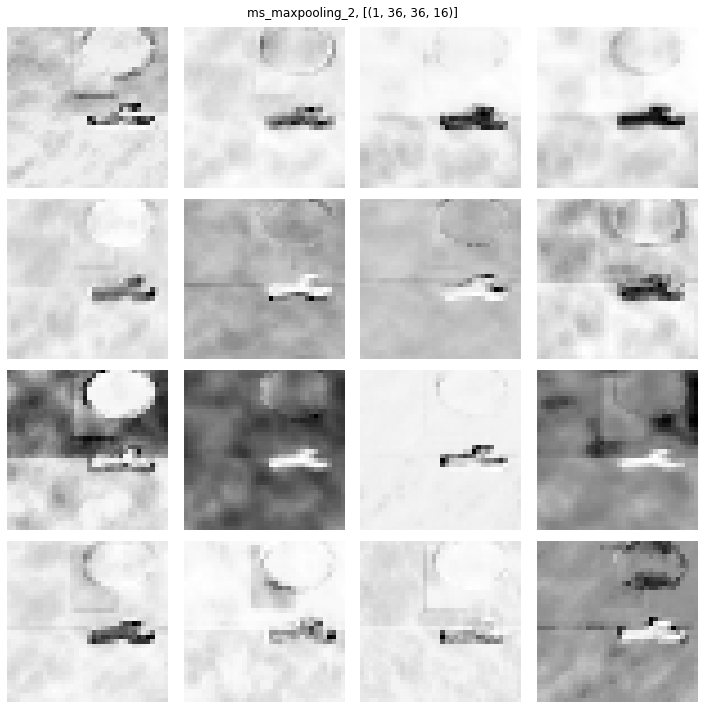

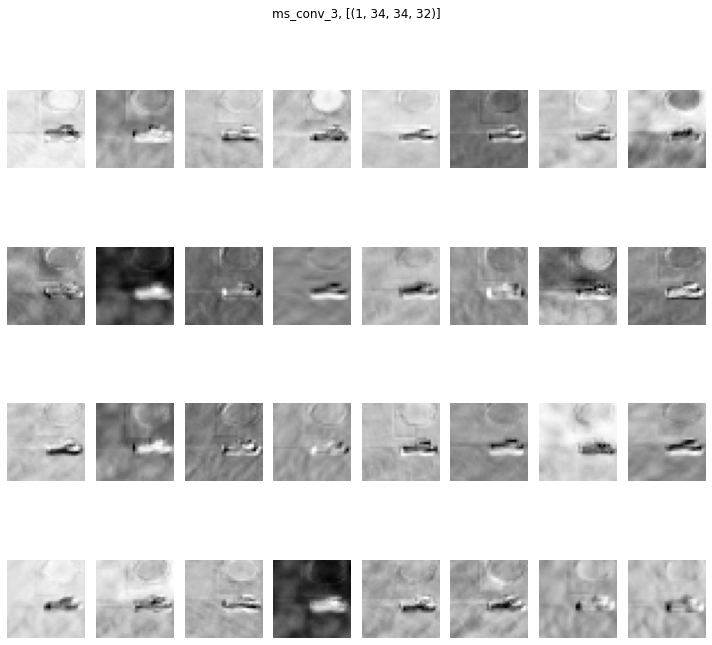

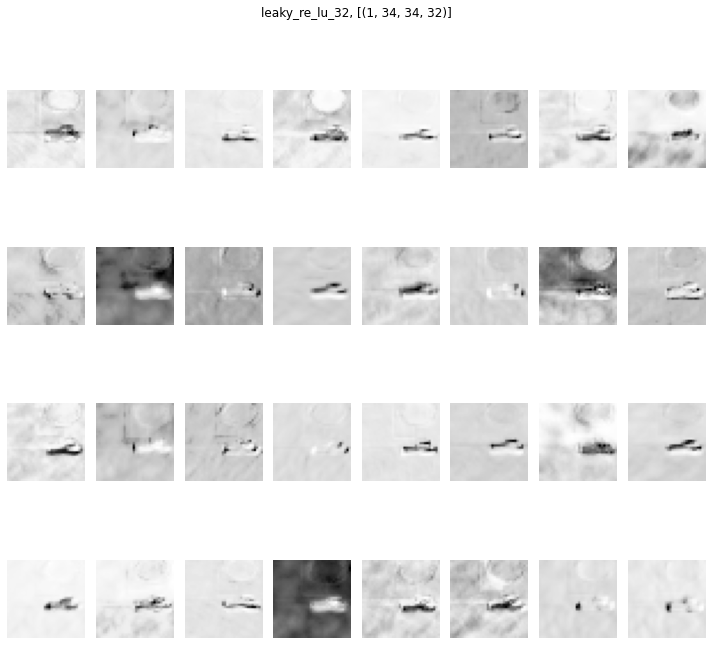

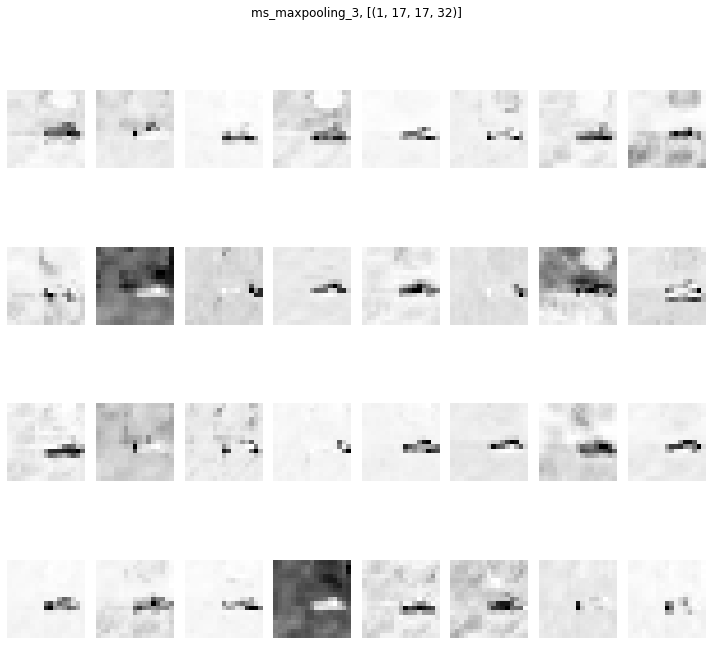

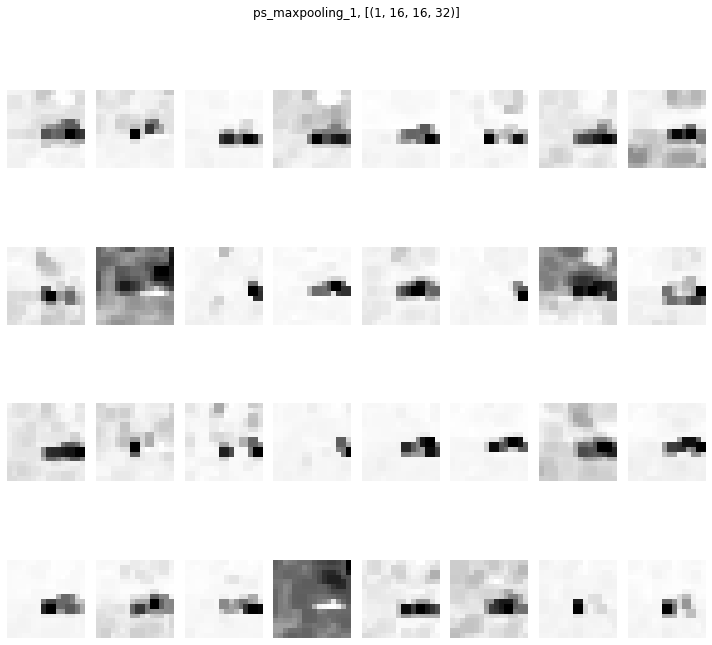

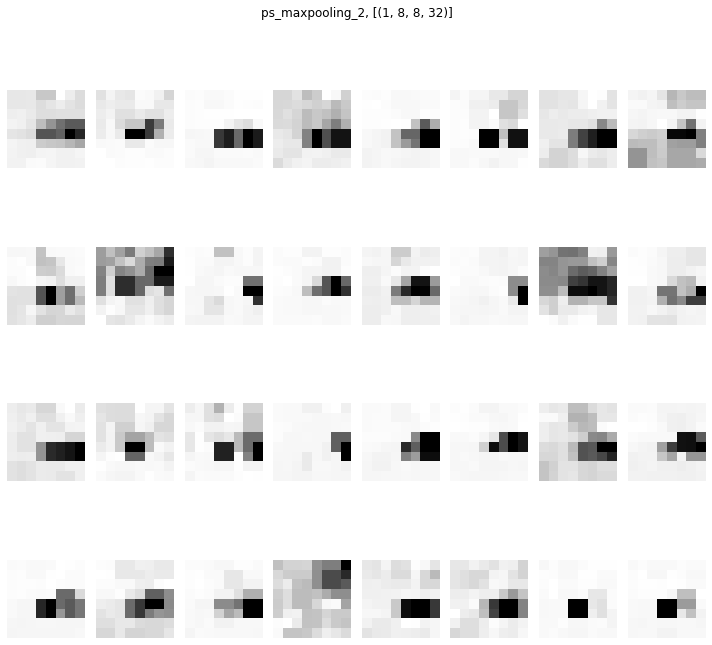

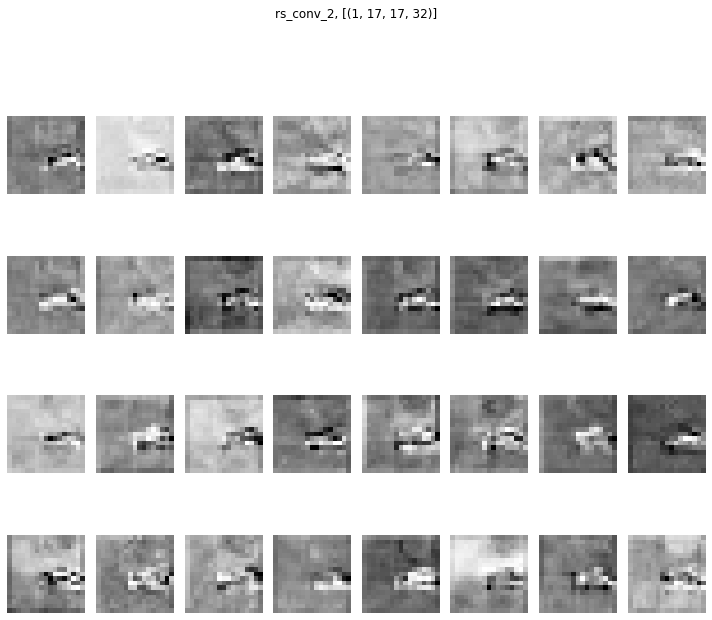

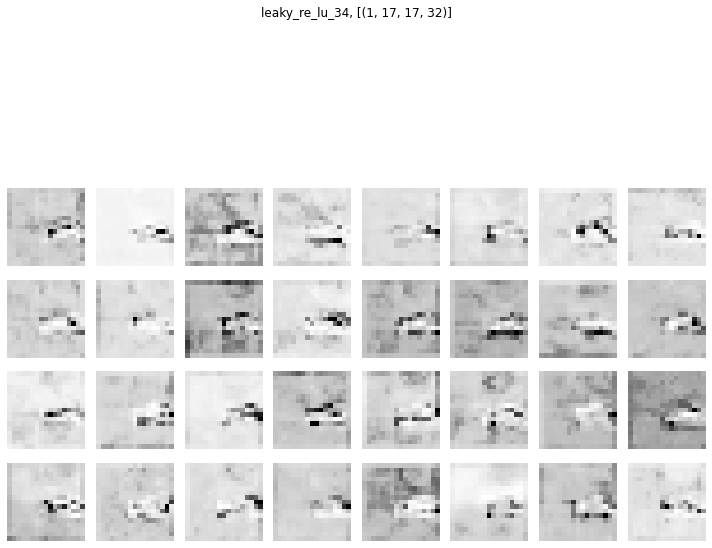

In [64]:
for layer in model.layers:
    extract_layer_data(layer)

In [67]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

In [73]:
plt.rcParams.update({'font.size': 15})